<a href="https://colab.research.google.com/github/iamacaru/TT12324-codigo/blob/main/TextClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entregable III. Construcción de un modelo de clasificación de texto

El objetivo del este notebook es crear un modelo de clasificación de texto usando una aproximación de ULMFit.

## Cargar las librerías

Comenzamos cargando las librerías que vamos a usar a lo largo del notebook.

In [2]:
!pip install fastai -Uqq
!pip install datasets -Uqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 45.5 MB/s eta 0:00:00


In [72]:
import pandas as pd
from fastai.text.all import *
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from huggingface_hub import notebook_login
from huggingface_hub import push_to_hub_fastai
from sklearn.metrics import f1_score

## Dataset

Vamos a usar el dataset Climate Detection, un dataset para detectar si un texto está o no relacionado con el clima.

Descargamos el dataset usando el siguiente comando.

In [42]:
climate_detection_dataset = load_dataset("climatebert/climate_detection")

Generating train split:   0%|          | 0/1300 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

## Carga de datos

Cargamos el dataset en distintos dataframes de pandas.

In [43]:
train_df = climate_detection_dataset["train"].to_pandas()
test_df = climate_detection_dataset["test"].to_pandas()

train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

Procesamos el dataset para tenerlo en el formato adecuado.

In [44]:
train_df['set']=False
valid_df['set']=True
train_valid_df = pd.concat([train_df,valid_df])

## Modelo de lenguaje

Creamos un DataBlock a partir de nuestro dataframe.

In [45]:
db_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True,max_vocab=100000),
    get_items=ColReader('text'),
    splitter=RandomSplitter(0.1)
)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Creamos un dataLoader.

In [46]:
dls_lm = db_lm.dataloaders(train_valid_df, bs=128, seq_len=80)

Mostramos un batch.

In [47]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxunk 's xxmaj chief xxmaj risk xxmaj officer ( xxunk ) reports directly to the xxup ceo and is head of xxmaj enterprise xxmaj risk and xxmaj portfolio xxmaj management and chair of the xxmaj risk xxmaj management xxmaj committee ( xxunk ) . xxmaj the xxup xxunk is responsible for providing independent review and oversight of enterprise - wide risks and leadership on risk issues , developing and maintaining a risk management framework and fostering a strong risk","xxunk 's xxmaj chief xxmaj risk xxmaj officer ( xxunk ) reports directly to the xxup ceo and is head of xxmaj enterprise xxmaj risk and xxmaj portfolio xxmaj management and chair of the xxmaj risk xxmaj management xxmaj committee ( xxunk ) . xxmaj the xxup xxunk is responsible for providing independent review and oversight of enterprise - wide risks and leadership on risk issues , developing and maintaining a risk management framework and fostering a strong risk culture"
1,"obligations . xxmaj given that developments concerning the xxup covid-19 pandemic have been constantly evolving , additional impacts and risks may arise that we are not aware of or able to appropriately respond to at this time . xxbos xxmaj the xxunk list of risk factors is not exhaustive . xxmaj additional information about these factors can be found in the xxmaj risk xxmaj management section of the xxmaj bank 's 2019 xxmaj annual xxmaj report . xxmaj this information",". xxmaj given that developments concerning the xxup covid-19 pandemic have been constantly evolving , additional impacts and risks may arise that we are not aware of or able to appropriately respond to at this time . xxbos xxmaj the xxunk list of risk factors is not exhaustive . xxmaj additional information about these factors can be found in the xxmaj risk xxmaj management section of the xxmaj bank 's 2019 xxmaj annual xxmaj report . xxmaj this information may"


Creamos el Learner.

In [51]:
learn = language_model_learner(
    dls_lm,
    AWD_LSTM,
    drop_mult=0.3,
    metrics=[accuracy, Perplexity()]
).to_fp16()

Buscamos un learning rate correcto.

SuggestedLRs(valley=0.0030199517495930195)

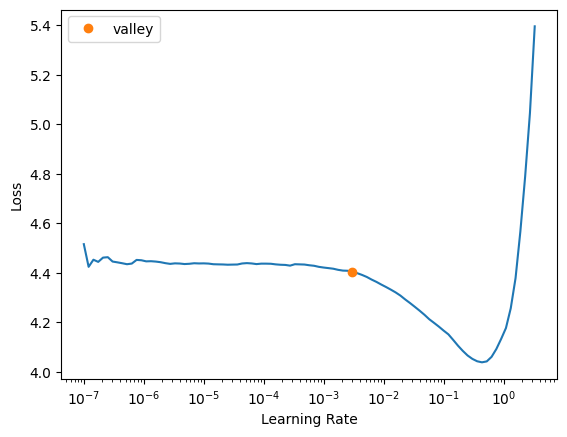

In [49]:
learn.lr_find()

Entrenamos el modelo.

In [52]:
learn.fine_tune(10,base_lr=0.0030199517495930195)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.408767,4.101895,0.281673,60.454762,00:10


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.174752,3.983722,0.285856,53.716595,00:09
1,4.095282,3.841554,0.295182,46.597816,00:09
2,3.999966,3.724552,0.306331,41.452675,00:12
3,3.918332,3.653997,0.312223,38.628773,00:09
4,3.838630,3.608279,0.312858,36.902481,00:11
5,3.769377,3.580204,0.316439,35.880867,00:08
6,3.703549,3.558164,0.316602,35.098694,00:10
7,3.645516,3.546500,0.315853,34.691673,00:12
8,3.597920,3.542956,0.317269,34.568966,00:10
9,3.562155,3.542324,0.316895,34.547115,00:09


Guardamos el encoder que usaremos luego para nuestro modelo de clasificación.

In [53]:
learn.save_encoder('finetuned')

## Entrenando un modelo de clasificación

Definimos un DataBlock que se creará a partir del dataframe df.

In [54]:
sentiment_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('label'),
    splitter=ColSplitter('set')
)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Definimos nuestro dataloader a partir del DataBlock que hemos creado.

In [55]:
dls = sentiment_clas.dataloaders(train_valid_df, bs=64)

Mostramos un batch de nuestro dataloader.

In [56]:
dls.show_batch(max_n=2)

,text,category
0,"xxbos 44 xxmaj national xxmaj australia xxmaj bank delayed in the 2020 financial year , due to xxup covid-19 , but is expected to be completed in the 2021 financial year . - xxmaj climate xxmaj measurement xxmaj standards xxmaj initiative ( cmsi ) - xxmaj the xxmaj group joined and supported this cross - sector industry initiative which formed in the 2020 financial year . xxmaj the xxup cmsi includes representatives from across the banking , insurance and investment sectors alongside pre - xxunk xxmaj australian climate xxunk working together under the xxunk of the xxmaj national xxmaj environmental xxmaj science xxmaj program 's xxmaj earth xxmaj systems and xxmaj climate xxmaj change ( xxunk ) xxmaj hub , professional services firms and finance sector industry bodies . xxmaj the objectives of the xxup cmsi are to provide xxunk source voluntary guidelines for financial institutions ( banks , insurers",1
1,"xxbos xxmaj in 2019 , we : - incorporated conduct risk management into our risk culture framework and xxunk up risk culture communication efforts xxmaj group - wide , with an emphasis on the xxmaj tone from the xxmaj top and xxmaj tone from xxmaj above ; - implemented a risk culture xxunk to provide regular updates to the xxmaj board and senior management ; - introduced measures to assess the results of the various risk culture initiatives , including feedback from senior management committees and an annual self - assessment exercise for key business and support units . xxmaj we also included more xxunk on risk culture in the xxmaj bank 's xxmaj employee xxmaj engagement xxmaj survey . xxup xxunk is also a member of the xxmaj culture and xxmaj conduct xxmaj steering xxmaj committee , established by the xxmaj monetary xxmaj authority of xxmaj singapore ( xxunk",1


Creamos el learner usando el método text_classifier_learner, que usará la arquitecturade red  AWD_LSTM, además aplicamos dropout a nuestro modelo.

In [57]:
callbacks = [ShowGraphCallback(),
             SaveModelCallback()]

learnClass = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy,cbs=callbacks).to_fp16()

Cargamos a el encoder del modelo de lenguaje.

In [61]:
learnClass = learnClass.load_encoder('finetuned')

Buscamos un learning rate correcto.

SuggestedLRs(valley=0.002511886414140463)

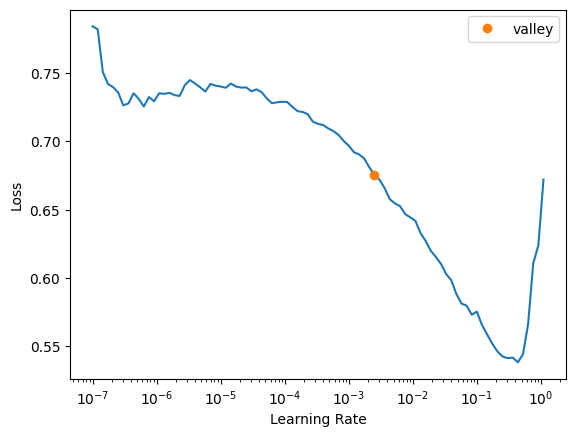

In [59]:
learnClass.lr_find()

Aplicamos fine tuning a nuestro modelo

epoch,train_loss,valid_loss,accuracy,time
0,0.471181,0.404387,0.876923,00:02


Better model found at epoch 0 with valid_loss value: 0.4043872654438019.


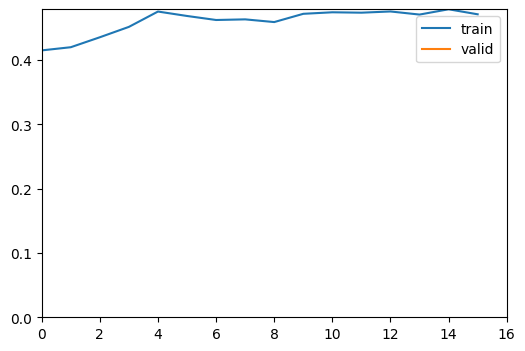

epoch,train_loss,valid_loss,accuracy,time
0,0.439193,0.330062,0.907692,00:02
1,0.403755,0.284188,0.919231,00:02
2,0.365585,0.299251,0.892308,00:02
3,0.333950,0.235287,0.911538,00:03
4,0.295843,0.223755,0.919231,00:02
5,0.251740,0.239428,0.919231,00:02
6,0.210814,0.229265,0.923077,00:02
7,0.174535,0.202327,0.926923,00:03
8,0.143896,0.195170,0.930769,00:02
9,0.130168,0.197755,0.919231,00:02


Better model found at epoch 0 with valid_loss value: 0.33006203174591064.


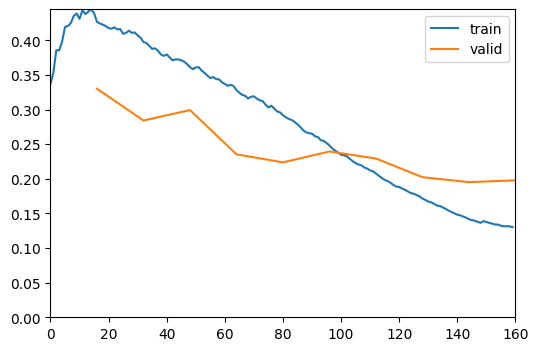

Better model found at epoch 1 with valid_loss value: 0.2841876745223999.
Better model found at epoch 3 with valid_loss value: 0.23528723418712616.
Better model found at epoch 4 with valid_loss value: 0.22375540435314178.
Better model found at epoch 7 with valid_loss value: 0.20232725143432617.
Better model found at epoch 8 with valid_loss value: 0.19517016410827637.


In [62]:
learnClass.fine_tune(10, 0.002511886414140463)

 Usamos nuestro modelo para predecir la clase de una frase nueva.

In [63]:
learnClass.predict('I use the public transport in order to produce less CO2')

('1', tensor(1), tensor([0.0654, 0.9346]))

Validamos nuestro modelo con el conjunto de test combinando los dataframes y construyendo un nuevo dataloader.

In [66]:
test_df['set']=True
train_test_df = pd.concat([train_df,test_df])
dls_test = sentiment_clas.dataloaders(train_test_df, bs=64)

Modificamos el dataloader del learner y validamos.

In [67]:
learnClass.dls = dls_test
learnClass.validate()

Better model found at epoch 0 with valid_loss value: 0.8774999976158142.


(#2) [0.3701378107070923,0.8774999976158142]

## Creando una aplicación para usar el modelo

Con el fin de poder usar el modelo construiremos una pequeña aplicación mediante Gradio y HuggingFace.

Primero descargamos la librería necesaria.

In [68]:
!pip install huggingface_hub["fastai"] -Uq

A continuación nos autenticamos mediante el token creado.

In [71]:
notebook_login()

Ahora subiremos el modelo indicando nuestro nombre de usuario y un nombre para el modelo.

In [74]:
repo_id = "iamacaru/climate"

push_to_hub_fastai(learner=learnClass, repo_id=repo_id)

model.pkl:   0%|          | 0.00/133M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/iamacaru/climate/commit/273a5b8d4a1be4646230809b24afef4273b0af2b', commit_message='Push FastAI model using huggingface_hub.', commit_description='', oid='273a5b8d4a1be4646230809b24afef4273b0af2b', pr_url=None, pr_revision=None, pr_num=None)

Tras crear la aplicación podemos acceder a ella desde [aquí](https://huggingface.co/spaces/iamacaru/entregable3).

O usando el siguiente URL: https://huggingface.co/spaces/iamacaru/entregable3

## Técnica de ensemble

Vamos a aplicar la técnica de ensemble, por lo que procedemos a crear otro modelo.

Creamos el conjunto a partir del original invirtiendo el orden de las palabras, definimos un DataBlock y creamos el learner y le cargamos el modelo de lenguaje.

In [ ]:
train_valid_df_bwd = train_valid_df.copy()
train_valid_df_bwd['text'] = train_valid_df_bwd['text'].apply(lambda x: ' '.join(reversed(x.split())))

sentiment_clas_bwd = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('label'),
    splitter=ColSplitter('set')
)

dls_bwd = sentiment_clas_bwd.dataloaders(train_valid_df_bwd, bs=64)
learnClass_bwd = text_classifier_learner(dls_bwd, AWD_LSTM, drop_mult=0.5, metrics=accuracy, cbs=callbacks).to_fp16()
learnClass_bwd = learnClass_bwd.load_encoder('finetuned')

Buscamos un learning rate correcto.

In [ ]:
learnClass_bwd.lr_find()

Entrenamos el modelo.

In [ ]:
learnClass_bwd.fine_tune(10, )

Vemos los resultados.

In [ ]:
@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [ ]:
preds, targs = learnClass.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

In [ ]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

In [ ]:
preds_avg = (preds + preds_b) / 2
accuracy(preds_avg, targs_b), f1(preds_avg, targs_b)